Optical field calculation using the Fourier Modal Method
====

In [20]:
%reset

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, linalg, integrate

# Part 1. Eigenmode calculation

In [54]:
%reset

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, linalg, integrate

Nothing done.


In [55]:
# set up constants and parameters for the Air-grating-substrate setup

N=25                       # summation limits
M=2*N+1                    # Total Number of plane wave terms included in expansion
spatialresolution=250

L=385e-9                   # height of substrate (layer 2) in m
wavelength=633e-9          # wavelength of light in m
thetaDegree=0              # angle of incidence in degrees 

theta=thetaDegree*2*np.pi/360   # Angle of incidence in radians

epsilon1=1
epsilon2=1.5**2

n1=np.sqrt(epsilon1)
n2=np.sqrt(epsilon2)

k1=n1*2*np.pi/wavelength    # k vector in layer 1 (air)
k0=k1                       # define k0 same as in air
k3=n2*(2*np.pi)/wavelength  # k vector in layer 3 (glass substrate)
GratePeriod=800e-9          # grating period, the periodicity in the x-direction in layer 2
f=0.32                      # filling factor a/Lamda
a=GratePeriod*f             # the thickness of each grate-layer

G=2*np.pi/GratePeriod
GrateSpacing=GratePeriod-a

ztop12=GratePeriod/2        # top of computational domain
zbot12=-GratePeriod/2       # bottom of computational domain

In [56]:
# Construct the matrices
kx=k1*np.sin(theta)

# reallocate matrices
A=np.zeros((M,M), dtype=np.complex_)
B=np.zeros((M,M), dtype=np.complex_)

Nvec=np.linspace(-N,N,M)
Nvec2=np.linspace(-2*N,2*N,4*N+1)
A=np.diag(Nvec*G+kx)**2

In [57]:
def sortem(eigenVectors, eigenValues):
    idx = eigenValues.argsort()[::-1]   
    return eigenVectors[:,idx], eigenValues[idx]

eps2vec = np.zeros(len(Nvec2), dtype=np.complex_)
for j in range(len(Nvec2)):
    eps2vec[j]=(1/GratePeriod) * (np.divide(1, (-1j*G*Nvec2[j]))) * ( epsilon2*(np.exp(-1j*Nvec2[j]*G*a) - 1) + epsilon1*(np.exp(-1j*Nvec2[j]*G*GratePeriod)-np.exp(-1j*Nvec2[j]*G*a)) )

eps2vec[M-1] = (epsilon2*a+epsilon1*(GrateSpacing-a))/GratePeriod

for j in range(M):
    for u in range(M):
      B[j,u]=eps2vec[M+j-u-1]

eigmat1=-A+(k0**2)*B
betasquared1, eigvecunnorm1 = linalg.eig(eigmat1)
betasquared1 = np.real(betasquared1)
eigvecunnorm, betasquared=sortem(eigvecunnorm1, betasquared1)

C:\Users\amcar\AppData\Local\Temp\ipykernel_105788\1535246338.py:7: RuntimeWarning: divide by zero encountered in divide
  eps2vec[j]=(1/GratePeriod) * (np.divide(1, (-1j*G*Nvec2[j]))) * ( epsilon2*(np.exp(-1j*Nvec2[j]*G*a) - 1) + epsilon1*(np.exp(-1j*Nvec2[j]*G*GratePeriod)-np.exp(-1j*Nvec2[j]*G*a)) )
C:\Users\amcar\AppData\Local\Temp\ipykernel_105788\1535246338.py:7: RuntimeWarning: invalid value encountered in divide
  eps2vec[j]=(1/GratePeriod) * (np.divide(1, (-1j*G*Nvec2[j]))) * ( epsilon2*(np.exp(-1j*Nvec2[j]*G*a) - 1) + epsilon1*(np.exp(-1j*Nvec2[j]*G*GratePeriod)-np.exp(-1j*Nvec2[j]*G*a)) )
C:\Users\amcar\AppData\Local\Temp\ipykernel_105788\1535246338.py:7: RuntimeWarning: invalid value encountered in scalar multiply
  eps2vec[j]=(1/GratePeriod) * (np.divide(1, (-1j*G*Nvec2[j]))) * ( epsilon2*(np.exp(-1j*Nvec2[j]*G*a) - 1) + epsilon1*(np.exp(-1j*Nvec2[j]*G*GratePeriod)-np.exp(-1j*Nvec2[j]*G*a)) )


In [58]:
# Determine the normalization constant
C = np.zeros(M, dtype=np.complex_)
eigvecnorm = np.zeros(eigvecunnorm.shape, dtype=np.complex_)
for j in range(M):
    C[j]=np.emath.sqrt(betasquared[j])*GratePeriod*(np.linalg.norm(eigvecunnorm[j])**2)
    eigvecnorm[j]=np.divide(1, np.emath.sqrt(C[j]))*eigvecunnorm[j]

In [59]:
# Now we find the E-field in the y-direction

xvec=np.linspace(0,GratePeriod,spatialresolution)
zvec12=np.linspace(zbot12,ztop12,spatialresolution)
# this is the calculation of the fundamental mode - we can also calculate
# the rest, but it is computationally heavy

u1matunsorted=np.diag(np.ones(M, dtype=np.complex_))
beta1unsorted=np.emath.sqrt(epsilon1*(k0**2)*np.ones(M)-(kx*np.ones(M)+G*Nvec)**2)

u1mat, beta1vec=sortem(u1matunsorted, (beta1unsorted**2))
beta1=np.emath.sqrt(beta1vec)

for j in range(M):
    C[j]=np.emath.sqrt(beta1vec[j])*GratePeriod*(np.linalg.norm(u1mat[j])**2)
    u1mat[j]=np.divide(1, np.emath.sqrt(C[j]))*u1mat[j]


In [60]:
u3matunsorted=np.diag(np.ones(M, dtype=np.complex_))
beta3unsorted=np.emath.sqrt(epsilon2*(k0**2)*np.ones(M)-(kx*np.ones(M)+G*Nvec)**2)

u3mat, beta3vec=sortem(u3matunsorted,(beta3unsorted**2))
beta3=np.emath.sqrt(beta3vec)

for j in range(M):
    C[j]=np.emath.sqrt(beta3vec[j])*GratePeriod*(np.linalg.norm(u3mat[j])**2)
    u3mat[j]=np.divide(1, np.emath.sqrt(C[j]))*u3mat[j]

Ey2fundamental = np.zeros((spatialresolution, 1), dtype=np.complex_)
Ey1full = np.zeros((spatialresolution, M), dtype=np.complex_)
Ey2full = np.zeros((spatialresolution, M), dtype=np.complex_)
Ey3full = np.zeros((spatialresolution, M), dtype=np.complex_)
for j in range(spatialresolution):
    Ey2fundamental[j]=eigvecnorm[:, 0].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M,1)*G)*xvec[j])
    for n in range(M):     # Compute the full set
        Ey2full[j,n]=eigvecnorm[:, n].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M, 1)*G)*xvec[j])
        Ey1full[j,n]=u1mat[:, n].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M, 1)*G)*xvec[j])
        Ey3full[j,n]=u3mat[:, n].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M, 1)*G)*xvec[j])

# Here we find the phase that will make the fundamental mode purely real
FundamentalRealPhase=np.arctan(np.imag(Ey2fundamental[0])/np.real(Ey2fundamental[0]))
Ey2fundamentalreal=Ey2fundamental*np.exp(-1j*FundamentalRealPhase)

C:\Users\amcar\AppData\Local\Temp\ipykernel_105788\2944913722.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ey2full[j,n]=eigvecnorm[:, n].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M, 1)*G)*xvec[j])
C:\Users\amcar\AppData\Local\Temp\ipykernel_105788\2944913722.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ey1full[j,n]=u1mat[:, n].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M, 1)*G)*xvec[j])
C:\Users\amcar\AppData\Local\Temp\ipykernel_105788\2944913722.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single el

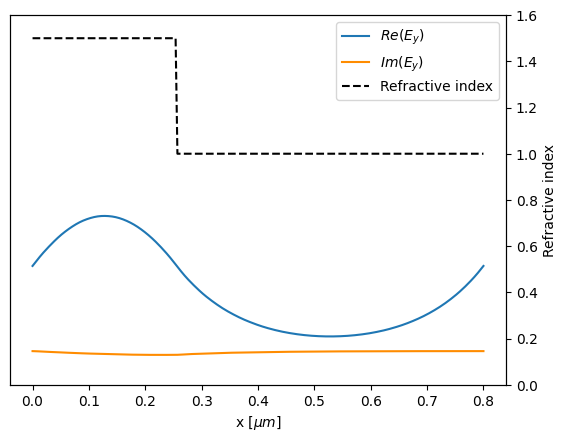

In [61]:
epsvec=np.concatenate([(epsilon2*np.ones(int(f*spatialresolution))), (epsilon1*np.ones(int(spatialresolution-f*spatialresolution)))])

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(xvec*(10**6), np.real(Ey2fundamentalreal), label="$Re(E_y)$")
lns2 = ax1.plot(xvec*(10**6), np.imag(Ey2fundamentalreal), color="darkorange", label="$Im(E_y)$")
lns3 = ax2.plot(xvec*(10**6), np.sqrt(epsvec), color="black", linestyle="--", label="Refractive index")

ax1.set_xlabel("x [$\mu m$]")
ax2.set_ylabel("Refractive index")

ax1.set_yticks([])
ax1.set_ylim([-0.05, .5])
ax2.set_ylim([0, 1.6])

# build legend
lns = lns1+lns2+lns3
labs = [ln.get_label() for ln in lns]
ax1.legend(lns, labs, loc='upper right')
plt.show()

# Part 2. Reflection and transmission at an interface

In [63]:
u2mat=eigvecnorm
beta2=np.emath.sqrt(betasquared)

tmat12=2*np.linalg.pinv( np.linalg.pinv(u1mat) @ u2mat + np.linalg.pinv(u1mat @ np.diag(beta1)) @ (u2mat @ np.diag(np.emath.sqrt(betasquared))) )
tmat21=2*np.linalg.pinv( np.linalg.pinv(u2mat) @ u1mat + np.linalg.pinv(u2mat @ np.diag(np.emath.sqrt(betasquared))) @ (u1mat@np.diag(beta1)) )

rmat12=1/2*( np.linalg.pinv(u1mat)@u2mat - np.linalg.pinv(u1mat@np.diag(beta1))@(u2mat@np.diag(np.emath.sqrt(betasquared))) )@tmat12
rmat21=1/2*(np.linalg.pinv(u2mat)@u1mat - np.linalg.pinv(u2mat@np.diag(np.emath.sqrt(betasquared)))@(u1mat@np.diag(beta1)))@tmat21

In [64]:
IncIndex=0              # N+1; %choose the m=0 mode is incoming, corresponding to light with no incidence angle
a1vec=np.zeros((M,1))
a1vec[IncIndex, 0]=1       # only the m=0 mode is incoming, corresponding to light with no incidence angle.

p1mvec12=np.exp(-1j*beta1*zbot12).reshape(M,1)
a1primevec12=p1mvec12*a1vec

b1vec12=rmat12@a1primevec12
a2vec12=tmat12@a1primevec12

EField12=np.zeros((spatialresolution,spatialresolution), dtype=np.complex_)  # (x,z)


In [65]:
for j in range(int(np.floor(spatialresolution/2))):         # z-coordinate
    for u in range(spatialresolution):                      # x-coordinate
        # Need to fix the order of matrix mult so that the indices match in
        # the end and we get the right sum
        EField12[u,j]=Ey1full[u,:].reshape(1,M) @ (a1vec*np.exp(1j*(beta1.reshape(M,1))*(zvec12[j]-zbot12))) + Ey1full[u,:].reshape(1,M) @ (b1vec12*(np.exp(-1j*beta1.reshape(M,1)*zvec12[j])))
        EField12[u, (int(np.floor(spatialresolution/2))+j)]=Ey2full[u,:].reshape(1,M) @ (a2vec12*np.exp(1j*beta2.reshape(M,1)*zvec12[(int(np.floor(spatialresolution/2))+j)]))


C:\Users\amcar\AppData\Local\Temp\ipykernel_105788\4159220615.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  EField12[u,j]=Ey1full[u,:].reshape(1,M) @ (a1vec*np.exp(1j*(beta1.reshape(M,1))*(zvec12[j]-zbot12))) + Ey1full[u,:].reshape(1,M) @ (b1vec12*(np.exp(-1j*beta1.reshape(M,1)*zvec12[j])))
C:\Users\amcar\AppData\Local\Temp\ipykernel_105788\4159220615.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  EField12[u, (int(np.floor(spatialresolution/2))+j)]=Ey2full[u,:].reshape(1,M) @ (a2vec12*np.exp(1j*beta2.reshape(M,1)*zvec12[(int(np.floor(spatialresolution/2))+j)]))


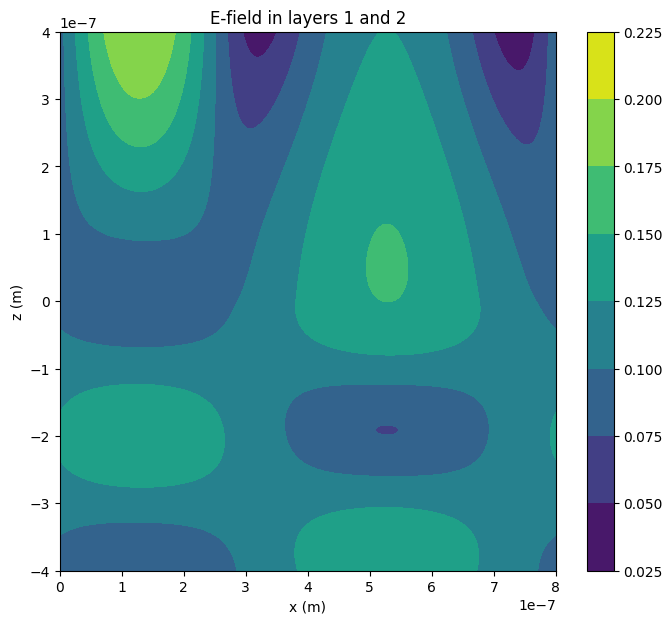

In [66]:
plt.figure(figsize=(8,7))
plt.contourf(xvec, zvec12, np.absolute(EField12.T))
plt.title('E-field in layers 1 and 2')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.show()

# Part 3. Full three-layer geometry

In [67]:
# Part 3 -  we calculate completely new z-direction dependence!
# Set up the z axis
zmax=2e-6   # 2 micrometers
zbot=-1e-6  # 1 micrometer below the barrier

zvec=np.linspace(zbot,zmax,spatialresolution)

# Determine the rest of the transmission and reflection coefficients
tmat23=2*np.linalg.pinv( np.linalg.pinv(u2mat) @ u3mat + np.linalg.pinv(u2mat @ np.diag(beta2)) @ (u3mat @ np.diag(beta3)))
tmat32=2*np.linalg.pinv( np.linalg.pinv(u3mat) @ u2mat + np.linalg.pinv(u3mat @ np.diag(beta3)) @ (u2mat@ np.diag(beta2)))

rmat23=1/2*( np.linalg.pinv(u2mat)@u3mat - np.linalg.pinv(u2mat@np.diag(beta2))@(u3mat@np.diag(beta3)) ) @ tmat23
rmat32=1/2*( np.linalg.pinv(u3mat)@u2mat - np.linalg.pinv(u3mat@np.diag(beta3))@(u2mat@np.diag(beta2)) ) @ tmat32

p1mvec=np.exp(-1j*beta1*zbot).reshape(M,1)
a1primevec=p1mvec*a1vec

p2mvec=np.exp(1j*beta2*L)   # propagator in middle layer
p2mat=np.diag(p2mvec)


In [68]:
SandwichMatrix=np.linalg.pinv(np.eye(M,M)-rmat21@p2mat@rmat23@p2mat)
rmat13=rmat12+tmat21@p2mat@rmat23@p2mat@SandwichMatrix@tmat12
tmat13=tmat23@p2mat@SandwichMatrix@tmat12

# In the 3-layer system we have a new a2vec and b1vec and we now have a b2vec due to
# backward propagating reflections.
b1vec=rmat13@a1primevec

a2vec=SandwichMatrix@tmat12@a1primevec
SandwichMatrix2 = np.linalg.pinv(np.eye(M,M)-rmat23@p2mat@rmat21@p2mat)
b2vec=SandwichMatrix2@rmat23@p2mat@tmat12@a1primevec

a2primevec=p2mvec*a2vec
a3vec=tmat13@a1primevec

In [69]:
EFieldFull=np.zeros((spatialresolution,spatialresolution), dtype=np.complex_)

for j in range(spatialresolution): # z-coordinate
    for u in range(spatialresolution):  # x-coordinate
        if zvec[j]<0:
            EFieldFull[u,j]=Ey1full[u,:].reshape(1,M) @ (a1vec*np.exp(1j*beta1.reshape(M,1)*(zvec[j]-zbot))) + Ey1full[u,:].reshape(1,M) @ (b1vec*np.exp(-1j*beta1.reshape(M,1)*zvec[j]))  # Field in layer 1
        elif ((zvec[j]>=0) & (zvec[j]<L)):
            EFieldFull[u,j]=Ey2full[u,:].reshape(1,M) @ (a2vec*np.exp(1j*beta2.reshape(M,1)*zvec[j])) + Ey2full[u,:].reshape(1,M) @ (b2vec*np.exp(-1j*beta2.reshape(M,1)*(zvec[j]-L)))     # Field in layer 2
        elif zvec[j]>=L:
            EFieldFull[u,j]=Ey3full[u,:].reshape(1,M) @ (a3vec*np.exp(1j*beta3.reshape(M,1)*(zvec[j]-L)))   # Field in layer 3

C:\Users\amcar\AppData\Local\Temp\ipykernel_105788\2696468887.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  EFieldFull[u,j]=Ey1full[u,:].reshape(1,M) @ (a1vec*np.exp(1j*beta1.reshape(M,1)*(zvec[j]-zbot))) + Ey1full[u,:].reshape(1,M) @ (b1vec*np.exp(-1j*beta1.reshape(M,1)*zvec[j]))  # Field in layer 1
C:\Users\amcar\AppData\Local\Temp\ipykernel_105788\2696468887.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  EFieldFull[u,j]=Ey2full[u,:].reshape(1,M) @ (a2vec*np.exp(1j*beta2.reshape(M,1)*zvec[j])) + Ey2full[u,:].reshape(1,M) @ (b2vec*np.exp(-1j*beta2.reshape(M,1)*(zvec[j]-L)))     # Field in layer 2
C:\Users\amcar\AppData\Local\T

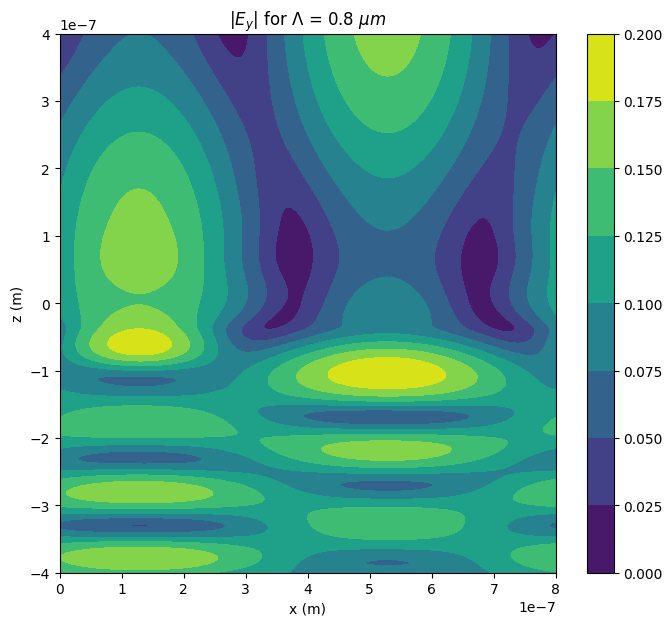

In [70]:
plt.figure(figsize=(8,7))
plt.contourf(xvec, zvec12, np.absolute(EFieldFull.T))
plt.title(f"$|E_y|$ for $\Lambda$ = {round(GratePeriod*1e6, 1)} $\mu m$")
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.show()

In [83]:
L = np.arange(0, 600e-9, 5e-9)
p2 = np.zeros((M, M, len(L)), dtype=np.complex_)
r13 = np.zeros((M, M, len(L)), dtype=np.complex_)
ModalRef = np.zeros((len(L),1))

In [81]:
for i, LL in enumerate(L):
    p2mvecL=np.exp(1j*beta2*LL)   # propagator in middle layer
    p2matL=np.diag(p2mvecL)
    SandwichMatrixL = np.linalg.pinv(np.eye(M,M) - rmat21@ p2matL @rmat23@ p2matL)
    rmat13L = rmat12 + tmat21 @ p2matL @rmat23@ p2matL @ SandwichMatrixL @ tmat12
    ModalRef[i] = np.abs(rmat13L[0,0])**2

In [53]:
ModalRefLL = ModalRef

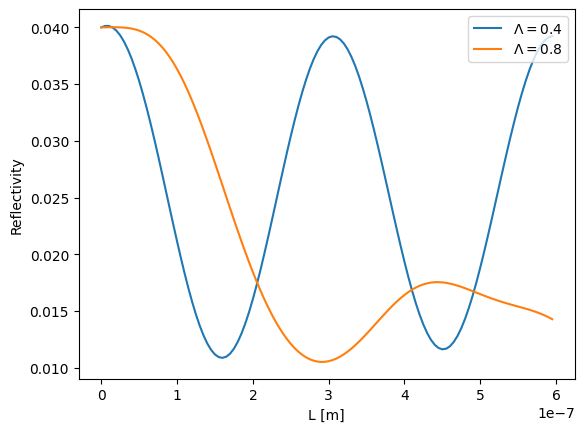

In [82]:
plt.figure()
plt.plot(L,ModalRefLL, label="$\Lambda = 0.4$")
plt.plot(L,ModalRef, label="$\Lambda = 0.8$")
plt.xlabel('L [m]')
plt.ylabel('Reflectivity')
plt.legend(loc='upper right')
plt.show()